In [4]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [5]:
x_train = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 5


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2179, Adversarial loss: 0.7731, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.6154, Adversarial loss: 0.7352, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.5735, Adversarial loss: 0.7352, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.5404, Adversarial loss: 0.7358, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.5173, Adversarial loss: 0.7138, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.5178, Adversarial loss: 0.7167, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.4789, Adversarial loss: 0.7078, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.4813, Adversarial loss: 0.7078, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.4747, Adversarial loss: 0.7101, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5097 - loss: 0.9657 - val_accuracy: 0.4130 - val_loss: 0.9888
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5075 - loss: 0.9089 - val_accuracy: 0.4493 - val_loss: 0.9006
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.5203 - loss: 0.8469 - val_accuracy: 0.4928 - val_loss: 0.8324
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.4913 - loss: 0.8313 - val_accuracy: 0.5145 - val_loss: 0.7767
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.5171 - loss: 0.7986 - val_accuracy: 0.5507 - val_loss: 0.7403
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.5055 - loss: 0.7707 - val_accuracy: 0.5725 - val_loss: 0.7110
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5250 - loss: 0.7471 - val_accuracy: 0.6087 - val_loss: 0.6894
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.5212 - loss: 0.7355 - val_accuracy: 0.6232

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5271 - loss: 0.8128 - val_accuracy: 0.5072 - val_loss: 0.7486
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.5162 - loss: 0.7884 - val_accuracy: 0.5435 - val_loss: 0.6983
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 0.7241 - val_accuracy: 0.5870 - val_loss: 0.6703
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.5805 - loss: 0.6937 - val_accuracy: 0.6159 - val_loss: 0.6486
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.5930 - loss: 0.6671 - val_accuracy: 0.6522 - val_loss: 0.6399
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6274 - loss: 0.6552 - val_accuracy: 0.7029 - val_loss: 0.6288
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6133 - loss: 0.6489 - val_accuracy: 0.6812 - val_loss: 0.6300
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.6344 - loss: 0.6411 - val_accuracy: 0.6594

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5157 - loss: 1.1352 - val_accuracy: 0.4493 - val_loss: 1.0576
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.5021 - loss: 1.0625 - val_accuracy: 0.4638 - val_loss: 0.9324
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.5395 - loss: 0.9613 - val_accuracy: 0.5000 - val_loss: 0.8479
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.5222 - loss: 0.8845 - val_accuracy: 0.5072 - val_loss: 0.7773
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.5264 - loss: 0.8476 - val_accuracy: 0.5507 - val_loss: 0.7247
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.5392 - loss: 0.7896 - val_accuracy: 0.5797 - val_loss: 0.6891
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.5767 - loss: 0.7399 - val_accuracy: 0.6014 - val_loss: 0.6639
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.5701 - loss: 0.7181 - val_accuracy: 0.60

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5634 - loss: 0.9278 - val_accuracy: 0.8261 - val_loss: 0.4102
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.5796 - loss: 0.8477 - val_accuracy: 0.8261 - val_loss: 0.4202
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.6038 - loss: 0.7404 - val_accuracy: 0.8043 - val_loss: 0.4411
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6151 - loss: 0.6886 - val_accuracy: 0.7971 - val_loss: 0.4703
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6368 - loss: 0.6443 - val_accuracy: 0.7899 - val_loss: 0.4996
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6545 - loss: 0.6261 - val_accuracy: 0.7826 - val_loss: 0.5293
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.6774 - loss: 0.5958 - val_accuracy: 0.7391 - val_loss: 0.5518
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.6690 - loss: 0.5944 - val_accuracy: 0.73

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5706 - loss: 0.8021 - val_accuracy: 0.6812 - val_loss: 0.6054
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.5891 - loss: 0.7538 - val_accuracy: 0.6667 - val_loss: 0.5961
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6001 - loss: 0.7212 - val_accuracy: 0.6667 - val_loss: 0.5951
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6244 - loss: 0.6741 - val_accuracy: 0.6739 - val_loss: 0.5897
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6475 - loss: 0.6488 - val_accuracy: 0.6884 - val_loss: 0.5823
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.6499 - loss: 0.6348 - val_accuracy: 0.6812 - val_loss: 0.5856
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.6471 - loss: 0.6303 - val_accuracy: 0.6812 - val_loss: 0.5925
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.6646 - loss: 0.6106 - val_accuracy: 0.70

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6345 - loss: 0.6956 - val_accuracy: 0.5507 - val_loss: 0.7325
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6533 - loss: 0.6711 - val_accuracy: 0.5870 - val_loss: 0.6949
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6545 - loss: 0.6362 - val_accuracy: 0.6232 - val_loss: 0.6688
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.6589 - loss: 0.6266 - val_accuracy: 0.6594 - val_loss: 0.6485
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.6659 - loss: 0.6096 - val_accuracy: 0.6884 - val_loss: 0.6305
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6704 - loss: 0.6039 - val_accuracy: 0.6957 - val_loss: 0.6202
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6705 - loss: 0.6037 - val_accuracy: 0.6957 - val_loss: 0.6106
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.6651 - loss: 0.5944 - val_accuracy: 0.70

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4807 - loss: 0.9957 - val_accuracy: 0.3623 - val_loss: 1.0044
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.4946 - loss: 0.9307 - val_accuracy: 0.4275 - val_loss: 0.9321
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.5276 - loss: 0.8536 - val_accuracy: 0.4493 - val_loss: 0.8703
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5523 - loss: 0.7952 - val_accuracy: 0.4928 - val_loss: 0.8209
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5433 - loss: 0.7733 - val_accuracy: 0.5362 - val_loss: 0.7792
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.5703 - loss: 0.7307 - val_accuracy: 0.5362 - val_loss: 0.7521
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.5945 - loss: 0.7082 - val_accuracy: 0.5290 - val_loss: 0.7275
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5962 - loss: 0.6812 - val_accuracy: 0.52

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 0.8461 - val_accuracy: 0.4130 - val_loss: 0.8238
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.5211 - loss: 0.7779 - val_accuracy: 0.4130 - val_loss: 0.7935
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5284 - loss: 0.7397 - val_accuracy: 0.3768 - val_loss: 0.7739
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5398 - loss: 0.7114 - val_accuracy: 0.3913 - val_loss: 0.7543
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5773 - loss: 0.6805 - val_accuracy: 0.4203 - val_loss: 0.7331
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5775 - loss: 0.6725 - val_accuracy: 0.4275 - val_loss: 0.7247
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5855 - loss: 0.6726 - val_accuracy: 0.4565 - val_loss: 0.7101
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6223 - loss: 0.6602 - val_accuracy: 0.50

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5636 - loss: 0.9791 - val_accuracy: 0.5725 - val_loss: 0.9255
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.5972 - loss: 0.9383 - val_accuracy: 0.6014 - val_loss: 0.8732
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.6150 - loss: 0.8675 - val_accuracy: 0.5942 - val_loss: 0.8223
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.5976 - loss: 0.8522 - val_accuracy: 0.5942 - val_loss: 0.7828
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.5965 - loss: 0.7864 - val_accuracy: 0.6014 - val_loss: 0.7537
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.6252 - loss: 0.7373 - val_accuracy: 0.6232 - val_loss: 0.7231
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6254 - loss: 0.7199 - val_accuracy: 0.6377 - val_loss: 0.6972
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6319 - loss: 0.6929 - val_accuracy: 0.64

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5339 - loss: 1.0326 - val_accuracy: 0.7029 - val_loss: 0.6063
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5579 - loss: 0.9506 - val_accuracy: 0.7174 - val_loss: 0.5882
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.5661 - loss: 0.8686 - val_accuracy: 0.7246 - val_loss: 0.5795
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.5684 - loss: 0.8105 - val_accuracy: 0.7246 - val_loss: 0.5753
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5818 - loss: 0.7740 - val_accuracy: 0.7246 - val_loss: 0.5742
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.6002 - loss: 0.7055 - val_accuracy: 0.7246 - val_loss: 0.5770
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6169 - loss: 0.6853 - val_accuracy: 0.7101 - val_loss: 0.5791
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6428 - loss: 0.6374 - val_accuracy: 0.70

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4948 - loss: 1.1094 - val_accuracy: 0.6377 - val_loss: 0.6801
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.5120 - loss: 0.9868 - val_accuracy: 0.6377 - val_loss: 0.6847
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5337 - loss: 0.8591 - val_accuracy: 0.6232 - val_loss: 0.6930
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.5788 - loss: 0.7879 - val_accuracy: 0.5942 - val_loss: 0.7061
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6113 - loss: 0.7374 - val_accuracy: 0.6087 - val_loss: 0.7105
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6128 - loss: 0.7005 - val_accuracy: 0.5870 - val_loss: 0.7140
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6491 - loss: 0.6685 - val_accuracy: 0.5942 - val_loss: 0.7093
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6738 - loss: 0.6224 - val_accuracy: 0.60

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5220 - loss: 1.0160 - val_accuracy: 0.2681 - val_loss: 1.2625
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5332 - loss: 0.9214 - val_accuracy: 0.3043 - val_loss: 1.0884
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5592 - loss: 0.8246 - val_accuracy: 0.3551 - val_loss: 0.9492
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5541 - loss: 0.7725 - val_accuracy: 0.3841 - val_loss: 0.8549
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.5637 - loss: 0.7217 - val_accuracy: 0.4420 - val_loss: 0.7880
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6108 - loss: 0.6589 - val_accuracy: 0.4928 - val_loss: 0.7485
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6031 - loss: 0.6624 - val_accuracy: 0.5072 - val_loss: 0.7185
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6317 - loss: 0.6381 - val_accuracy: 0.52

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5805 - loss: 0.9350 - val_accuracy: 0.4783 - val_loss: 0.9608
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.5942 - loss: 0.8815 - val_accuracy: 0.5072 - val_loss: 0.8915
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5890 - loss: 0.8099 - val_accuracy: 0.5362 - val_loss: 0.8321
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6228 - loss: 0.7501 - val_accuracy: 0.5580 - val_loss: 0.7845
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6375 - loss: 0.7043 - val_accuracy: 0.5870 - val_loss: 0.7423
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6465 - loss: 0.6658 - val_accuracy: 0.6014 - val_loss: 0.7074
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6698 - loss: 0.6292 - val_accuracy: 0.6232 - val_loss: 0.6809
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6837 - loss: 0.6086 - val_accuracy: 0.63

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5044 - loss: 1.3067 - val_accuracy: 0.6594 - val_loss: 0.7239
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.4964 - loss: 1.2348 - val_accuracy: 0.6232 - val_loss: 0.7627
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.4801 - loss: 1.1015 - val_accuracy: 0.5942 - val_loss: 0.7817
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5197 - loss: 1.0031 - val_accuracy: 0.5797 - val_loss: 0.7949
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4863 - loss: 0.9907 - val_accuracy: 0.5507 - val_loss: 0.7991
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.5001 - loss: 0.9043 - val_accuracy: 0.5435 - val_loss: 0.7928
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4957 - loss: 0.8639 - val_accuracy: 0.5217 - val_loss: 0.7815
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.4863 - loss: 0.8496 - val_accuracy: 0.52

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6058 - loss: 0.8890 - val_accuracy: 0.5870 - val_loss: 0.8638
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6093 - loss: 0.8680 - val_accuracy: 0.5942 - val_loss: 0.8276
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6400 - loss: 0.7389 - val_accuracy: 0.5797 - val_loss: 0.7914
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6558 - loss: 0.7283 - val_accuracy: 0.5870 - val_loss: 0.7541
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6846 - loss: 0.6423 - val_accuracy: 0.5942 - val_loss: 0.7208
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6862 - loss: 0.6334 - val_accuracy: 0.6087 - val_loss: 0.7006
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7110 - loss: 0.5893 - val_accuracy: 0.6232 - val_loss: 0.6737
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7115 - loss: 0.5829 - val_accuracy: 0.63

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7556 - loss: 0.5189 - val_accuracy: 0.4928 - val_loss: 0.8828
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.7689 - loss: 0.4883 - val_accuracy: 0.5072 - val_loss: 0.8594
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.7767 - loss: 0.4915 - val_accuracy: 0.5290 - val_loss: 0.8358
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.7746 - loss: 0.4851 - val_accuracy: 0.5507 - val_loss: 0.8160
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.7696 - loss: 0.4832 - val_accuracy: 0.5435 - val_loss: 0.7987
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.7709 - loss: 0.4805 - val_accuracy: 0.5580 - val_loss: 0.7794
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7877 - loss: 0.4692 - val_accuracy: 0.5580 - val_loss: 0.7743
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7672 - loss: 0.4890 - val_accuracy: 0.57

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5681 - loss: 1.0262 - val_accuracy: 0.5217 - val_loss: 0.9673
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.6158 - loss: 0.9093 - val_accuracy: 0.5072 - val_loss: 0.9430
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.6328 - loss: 0.8083 - val_accuracy: 0.5072 - val_loss: 0.9175
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6441 - loss: 0.7545 - val_accuracy: 0.5072 - val_loss: 0.8871
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6579 - loss: 0.7132 - val_accuracy: 0.5145 - val_loss: 0.8579
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6761 - loss: 0.6773 - val_accuracy: 0.5290 - val_loss: 0.8219
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7027 - loss: 0.5856 - val_accuracy: 0.5290 - val_loss: 0.7931
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7164 - loss: 0.5996 - val_accuracy: 0.51

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3128 - loss: 1.4578 - val_accuracy: 0.6014 - val_loss: 0.7298
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.3058 - loss: 1.2752 - val_accuracy: 0.5725 - val_loss: 0.7468
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3015 - loss: 1.1708 - val_accuracy: 0.5072 - val_loss: 0.7616
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.2885 - loss: 1.0678 - val_accuracy: 0.4783 - val_loss: 0.7723
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.2825 - loss: 0.9833 - val_accuracy: 0.4130 - val_loss: 0.7790
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3087 - loss: 0.8928 - val_accuracy: 0.3768 - val_loss: 0.7762
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.3623 - loss: 0.8214 - val_accuracy: 0.3478 - val_loss: 0.7678
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.4001 - loss: 0.7694 - val_accuracy: 0.3261

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3459 - loss: 1.4510 - val_accuracy: 0.4855 - val_loss: 0.8559
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.3598 - loss: 1.3297 - val_accuracy: 0.4928 - val_loss: 0.8622
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.4118 - loss: 1.1236 - val_accuracy: 0.4275 - val_loss: 0.8669
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4500 - loss: 0.9872 - val_accuracy: 0.3841 - val_loss: 0.8635
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4687 - loss: 0.8768 - val_accuracy: 0.3768 - val_loss: 0.8457
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.5167 - loss: 0.7842 - val_accuracy: 0.4275 - val_loss: 0.8201
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.5545 - loss: 0.7241 - val_accuracy: 0.4783 - val_loss: 0.7930
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6264 - loss: 0.6635 - val_accuracy: 0.47

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6813 - loss: 0.6347 - val_accuracy: 0.7101 - val_loss: 0.6569
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.7062 - loss: 0.5770 - val_accuracy: 0.6884 - val_loss: 0.6683
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7489 - loss: 0.5331 - val_accuracy: 0.6739 - val_loss: 0.6776
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7424 - loss: 0.5190 - val_accuracy: 0.6739 - val_loss: 0.6836
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7651 - loss: 0.4871 - val_accuracy: 0.6739 - val_loss: 0.6879
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7829 - loss: 0.4746 - val_accuracy: 0.6667 - val_loss: 0.6890
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.8015 - loss: 0.4434 - val_accuracy: 0.6594 - val_loss: 0.6931
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7854 - loss: 0.4544 - val_accuracy: 0.65

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4335 - loss: 1.1822 - val_accuracy: 0.4203 - val_loss: 0.8772
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.4890 - loss: 1.0236 - val_accuracy: 0.5000 - val_loss: 0.7881
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5100 - loss: 0.9334 - val_accuracy: 0.5362 - val_loss: 0.7311
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5470 - loss: 0.8281 - val_accuracy: 0.5797 - val_loss: 0.6832
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5567 - loss: 0.7684 - val_accuracy: 0.5870 - val_loss: 0.6545
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6361 - loss: 0.6876 - val_accuracy: 0.6594 - val_loss: 0.6327
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6328 - loss: 0.6623 - val_accuracy: 0.6739 - val_loss: 0.6169
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6696 - loss: 0.6040 - val_accuracy: 0.67

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3595 - loss: 1.6506 - val_accuracy: 0.6667 - val_loss: 0.6823
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.3397 - loss: 1.4113 - val_accuracy: 0.6884 - val_loss: 0.6827
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.3897 - loss: 1.1857 - val_accuracy: 0.6449 - val_loss: 0.6976
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.4094 - loss: 1.0033 - val_accuracy: 0.5507 - val_loss: 0.7194
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.4841 - loss: 0.8455 - val_accuracy: 0.5072 - val_loss: 0.7416
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.5293 - loss: 0.7596 - val_accuracy: 0.4710 - val_loss: 0.7560
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.5968 - loss: 0.6677 - val_accuracy: 0.5000 - val_loss: 0.7625
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6519 - loss: 0.6218 - val_accuracy: 0.48

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5539 - loss: 0.8746 - val_accuracy: 0.3913 - val_loss: 1.1102
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.5909 - loss: 0.8038 - val_accuracy: 0.3986 - val_loss: 1.0338
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6186 - loss: 0.7005 - val_accuracy: 0.4203 - val_loss: 0.9681
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6676 - loss: 0.6292 - val_accuracy: 0.4565 - val_loss: 0.9152
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7048 - loss: 0.5673 - val_accuracy: 0.4928 - val_loss: 0.8700
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7157 - loss: 0.5517 - val_accuracy: 0.5290 - val_loss: 0.8308
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.7506 - loss: 0.4965 - val_accuracy: 0.5507 - val_loss: 0.8013
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7735 - loss: 0.4779 - val_accuracy: 0.55

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5635 - loss: 0.9717 - val_accuracy: 0.5290 - val_loss: 1.0615
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6201 - loss: 0.8507 - val_accuracy: 0.5652 - val_loss: 1.0136
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6422 - loss: 0.7855 - val_accuracy: 0.5797 - val_loss: 0.9651
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6538 - loss: 0.7360 - val_accuracy: 0.5870 - val_loss: 0.9216
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7053 - loss: 0.6487 - val_accuracy: 0.6014 - val_loss: 0.8824
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7052 - loss: 0.6092 - val_accuracy: 0.6159 - val_loss: 0.8499
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7178 - loss: 0.5679 - val_accuracy: 0.6232 - val_loss: 0.8149
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.7468 - loss: 0.5399 - val_accuracy: 0.63

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7110 - loss: 0.6175 - val_accuracy: 0.4493 - val_loss: 1.1188
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7486 - loss: 0.5427 - val_accuracy: 0.4710 - val_loss: 1.0471
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.7592 - loss: 0.5009 - val_accuracy: 0.4638 - val_loss: 0.9869
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.7735 - loss: 0.4609 - val_accuracy: 0.4783 - val_loss: 0.9395
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7872 - loss: 0.4368 - val_accuracy: 0.5072 - val_loss: 0.9030
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8184 - loss: 0.4047 - val_accuracy: 0.5290 - val_loss: 0.8786
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8092 - loss: 0.4061 - val_accuracy: 0.5435 - val_loss: 0.8524
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.8393 - loss: 0.3696 - val_accuracy: 0.55

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3845 - loss: 0.9466 - val_accuracy: 0.5072 - val_loss: 0.7867
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.4859 - loss: 0.8177 - val_accuracy: 0.5217 - val_loss: 0.7741
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5652 - loss: 0.7282 - val_accuracy: 0.5290 - val_loss: 0.7595
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6380 - loss: 0.6520 - val_accuracy: 0.5435 - val_loss: 0.7424
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7209 - loss: 0.5821 - val_accuracy: 0.5652 - val_loss: 0.7254
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7485 - loss: 0.5387 - val_accuracy: 0.5507 - val_loss: 0.7122
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7920 - loss: 0.4948 - val_accuracy: 0.5652 - val_loss: 0.7008
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.8046 - loss: 0.4607 - val_accuracy: 0.57

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 0.6742 - val_accuracy: 0.4420 - val_loss: 0.8471
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6766 - loss: 0.5897 - val_accuracy: 0.4710 - val_loss: 0.8054
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7052 - loss: 0.5620 - val_accuracy: 0.5217 - val_loss: 0.7710
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.7320 - loss: 0.5262 - val_accuracy: 0.5507 - val_loss: 0.7612
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7285 - loss: 0.4996 - val_accuracy: 0.5435 - val_loss: 0.7577
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.7221 - loss: 0.5034 - val_accuracy: 0.5362 - val_loss: 0.7668
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.7211 - loss: 0.4896 - val_accuracy: 0.5507 - val_loss: 0.7573
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.7568 - loss: 0.4700 - val_accuracy: 0.54

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4774 - loss: 0.9077 - val_accuracy: 0.4855 - val_loss: 0.7892
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5436 - loss: 0.7758 - val_accuracy: 0.5362 - val_loss: 0.7101
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6098 - loss: 0.6686 - val_accuracy: 0.5725 - val_loss: 0.6602
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6635 - loss: 0.6217 - val_accuracy: 0.6232 - val_loss: 0.6261
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7356 - loss: 0.5445 - val_accuracy: 0.6739 - val_loss: 0.6067
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7401 - loss: 0.5292 - val_accuracy: 0.6812 - val_loss: 0.5972
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7519 - loss: 0.5066 - val_accuracy: 0.7029 - val_loss: 0.5976
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.7865 - loss: 0.4800 - val_accuracy: 0.70

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4495 - loss: 0.9571 - val_accuracy: 0.4710 - val_loss: 0.8719
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.5242 - loss: 0.8401 - val_accuracy: 0.5145 - val_loss: 0.8382
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.6125 - loss: 0.7082 - val_accuracy: 0.5362 - val_loss: 0.8188
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6765 - loss: 0.6152 - val_accuracy: 0.5652 - val_loss: 0.8041
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7151 - loss: 0.5704 - val_accuracy: 0.5652 - val_loss: 0.7949
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.7479 - loss: 0.5340 - val_accuracy: 0.5797 - val_loss: 0.7867
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7798 - loss: 0.4821 - val_accuracy: 0.5725 - val_loss: 0.7838
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8047 - loss: 0.4590 - val_accuracy: 0.57

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4192 - loss: 1.0435 - val_accuracy: 0.5000 - val_loss: 0.8137
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.4979 - loss: 0.8976 - val_accuracy: 0.5145 - val_loss: 0.7778
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6317 - loss: 0.7297 - val_accuracy: 0.5435 - val_loss: 0.7506
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6815 - loss: 0.6391 - val_accuracy: 0.5362 - val_loss: 0.7410
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.7415 - loss: 0.5440 - val_accuracy: 0.5507 - val_loss: 0.7368
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7747 - loss: 0.4836 - val_accuracy: 0.5362 - val_loss: 0.7443
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.7970 - loss: 0.4468 - val_accuracy: 0.5507 - val_loss: 0.7480
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8289 - loss: 0.4132 - val_accuracy: 0.52

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_35 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.5099 - val_accuracy: 0.6594 - val_loss: 0.6527
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.8177 - loss: 0.4473 - val_accuracy: 0.6884 - val_loss: 0.6288
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.8336 - loss: 0.4380 - val_accuracy: 0.6812 - val_loss: 0.6224
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.8352 - loss: 0.4053 - val_accuracy: 0.6812 - val_loss: 0.6254
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.8466 - loss: 0.3880 - val_accuracy: 0.6957 - val_loss: 0.6220
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.8563 - loss: 0.3749 - val_accuracy: 0.6957 - val_loss: 0.6211
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.8543 - loss: 0.3680 - val_accuracy: 0.6884 - val_loss: 0.6170
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.8513 - loss: 0.3687 - val_accuracy: 0.68

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_36 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2248 - loss: 2.2324 - val_accuracy: 0.5145 - val_loss: 1.0810
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.2405 - loss: 1.9881 - val_accuracy: 0.5000 - val_loss: 0.9672
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.2736 - loss: 1.6473 - val_accuracy: 0.5072 - val_loss: 0.8761
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.2612 - loss: 1.4469 - val_accuracy: 0.5290 - val_loss: 0.8005
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3308 - loss: 1.1965 - val_accuracy: 0.5290 - val_loss: 0.7521
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3806 - loss: 1.0202 - val_accuracy: 0.5652 - val_loss: 0.7174
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.4387 - loss: 0.8904 - val_accuracy: 0.5652 - val_loss: 0.6951
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.5204 - loss: 0.7762 - val_accuracy: 0.61

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_37 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.8868 - val_accuracy: 0.3986 - val_loss: 1.2152
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6843 - loss: 0.7696 - val_accuracy: 0.4203 - val_loss: 1.0739
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7192 - loss: 0.6389 - val_accuracy: 0.4638 - val_loss: 0.9669
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7214 - loss: 0.5780 - val_accuracy: 0.4855 - val_loss: 0.8721
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7821 - loss: 0.5160 - val_accuracy: 0.5217 - val_loss: 0.8045
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7854 - loss: 0.4596 - val_accuracy: 0.5652 - val_loss: 0.7545
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.8233 - loss: 0.4134 - val_accuracy: 0.5870 - val_loss: 0.7254
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.8295 - loss: 0.3979 - val_accuracy: 0.59

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_38 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2132 - loss: 1.0062 - val_accuracy: 0.4348 - val_loss: 0.7815
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.2764 - loss: 0.8717 - val_accuracy: 0.5072 - val_loss: 0.7259
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3832 - loss: 0.7780 - val_accuracy: 0.5652 - val_loss: 0.6882
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5350 - loss: 0.6933 - val_accuracy: 0.6304 - val_loss: 0.6631
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6588 - loss: 0.6261 - val_accuracy: 0.6449 - val_loss: 0.6455
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7163 - loss: 0.5793 - val_accuracy: 0.6522 - val_loss: 0.6364
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7823 - loss: 0.5347 - val_accuracy: 0.6522 - val_loss: 0.6336
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.8010 - loss: 0.5054 - val_accuracy: 0.64

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_39 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8481 - loss: 0.4141 - val_accuracy: 0.7464 - val_loss: 0.5580
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.8668 - loss: 0.3729 - val_accuracy: 0.7536 - val_loss: 0.5843
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.8714 - loss: 0.3442 - val_accuracy: 0.7464 - val_loss: 0.6109
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.8901 - loss: 0.3199 - val_accuracy: 0.7319 - val_loss: 0.6365
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8978 - loss: 0.2972 - val_accuracy: 0.7101 - val_loss: 0.6614
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.8957 - loss: 0.2887 - val_accuracy: 0.7101 - val_loss: 0.6848
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8950 - loss: 0.2802 - val_accuracy: 0.7174 - val_loss: 0.7044
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.9008 - loss: 0.2764 - val_accuracy: 0.71

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_40 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2912 - loss: 1.7537 - val_accuracy: 0.6087 - val_loss: 0.7342
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.2934 - loss: 1.5046 - val_accuracy: 0.5870 - val_loss: 0.7384
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3321 - loss: 1.2341 - val_accuracy: 0.5725 - val_loss: 0.7558
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3807 - loss: 1.0475 - val_accuracy: 0.5217 - val_loss: 0.7752
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4219 - loss: 0.9186 - val_accuracy: 0.4855 - val_loss: 0.7890
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4862 - loss: 0.8162 - val_accuracy: 0.4565 - val_loss: 0.7944
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.5871 - loss: 0.7126 - val_accuracy: 0.4783 - val_loss: 0.7940
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.6298 - loss: 0.6488 - val_accuracy: 0.49

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_41 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6166 - loss: 0.7571 - val_accuracy: 0.5580 - val_loss: 0.7266
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6681 - loss: 0.6313 - val_accuracy: 0.5942 - val_loss: 0.6643
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7181 - loss: 0.5444 - val_accuracy: 0.6377 - val_loss: 0.6214
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7744 - loss: 0.4723 - val_accuracy: 0.6667 - val_loss: 0.5996
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.8103 - loss: 0.4348 - val_accuracy: 0.6957 - val_loss: 0.5856
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.8166 - loss: 0.4291 - val_accuracy: 0.7174 - val_loss: 0.5799
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8491 - loss: 0.3771 - val_accuracy: 0.7319 - val_loss: 0.5783
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.8592 - loss: 0.3573 - val_accuracy: 0.72

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_42 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3600 - loss: 1.1702 - val_accuracy: 0.3333 - val_loss: 0.9979
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.4290 - loss: 1.0194 - val_accuracy: 0.3478 - val_loss: 0.9407
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4873 - loss: 0.8732 - val_accuracy: 0.3841 - val_loss: 0.8875
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5374 - loss: 0.7731 - val_accuracy: 0.4058 - val_loss: 0.8422
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6086 - loss: 0.6808 - val_accuracy: 0.4130 - val_loss: 0.8091
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6726 - loss: 0.6128 - val_accuracy: 0.4928 - val_loss: 0.7787
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.7486 - loss: 0.5309 - val_accuracy: 0.5000 - val_loss: 0.7654
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7638 - loss: 0.4975 - val_accuracy: 0.51

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_43 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3914 - loss: 0.9295 - val_accuracy: 0.4130 - val_loss: 0.8216
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5788 - loss: 0.7283 - val_accuracy: 0.4783 - val_loss: 0.7745
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6700 - loss: 0.6160 - val_accuracy: 0.5362 - val_loss: 0.7387
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.7458 - loss: 0.5197 - val_accuracy: 0.5580 - val_loss: 0.7180
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7997 - loss: 0.4620 - val_accuracy: 0.5507 - val_loss: 0.7076
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8253 - loss: 0.4192 - val_accuracy: 0.5652 - val_loss: 0.7064
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8594 - loss: 0.3828 - val_accuracy: 0.5870 - val_loss: 0.7083
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.8697 - loss: 0.3642 - val_accuracy: 0.59

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_44 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5202 - loss: 1.0066 - val_accuracy: 0.4928 - val_loss: 0.8466
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5451 - loss: 0.9189 - val_accuracy: 0.5217 - val_loss: 0.7926
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.5823 - loss: 0.8216 - val_accuracy: 0.5435 - val_loss: 0.7455
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.6118 - loss: 0.7297 - val_accuracy: 0.5797 - val_loss: 0.7073
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6572 - loss: 0.6561 - val_accuracy: 0.6014 - val_loss: 0.6740
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6880 - loss: 0.5977 - val_accuracy: 0.6522 - val_loss: 0.6485
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.7398 - loss: 0.5301 - val_accuracy: 0.6812 - val_loss: 0.6282
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.7660 - loss: 0.5057 - val_accuracy: 0.68

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_45 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3989 - loss: 0.9813 - val_accuracy: 0.4493 - val_loss: 0.8099
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5286 - loss: 0.7743 - val_accuracy: 0.5217 - val_loss: 0.7703
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6396 - loss: 0.6501 - val_accuracy: 0.5290 - val_loss: 0.7527
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.7288 - loss: 0.5550 - val_accuracy: 0.5797 - val_loss: 0.7410
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7704 - loss: 0.4927 - val_accuracy: 0.6014 - val_loss: 0.7350
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.8139 - loss: 0.4288 - val_accuracy: 0.5942 - val_loss: 0.7360
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.8343 - loss: 0.4096 - val_accuracy: 0.5797 - val_loss: 0.7382
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8436 - loss: 0.3850 - val_accuracy: 0.58

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_46 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5276 - loss: 1.0082 - val_accuracy: 0.4710 - val_loss: 0.9627
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.5542 - loss: 0.9177 - val_accuracy: 0.5362 - val_loss: 0.8724
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6269 - loss: 0.8052 - val_accuracy: 0.5507 - val_loss: 0.8094
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6502 - loss: 0.6932 - val_accuracy: 0.5870 - val_loss: 0.7643
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6531 - loss: 0.6718 - val_accuracy: 0.6377 - val_loss: 0.7290
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6891 - loss: 0.6025 - val_accuracy: 0.6377 - val_loss: 0.7027
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7093 - loss: 0.5812 - val_accuracy: 0.6594 - val_loss: 0.6805
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7530 - loss: 0.5281 - val_accuracy: 0.67

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_47 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5816 - loss: 0.9691 - val_accuracy: 0.4710 - val_loss: 0.9336
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6247 - loss: 0.8177 - val_accuracy: 0.4783 - val_loss: 0.8474
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6777 - loss: 0.6494 - val_accuracy: 0.5217 - val_loss: 0.7876
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.7470 - loss: 0.5458 - val_accuracy: 0.6087 - val_loss: 0.7512
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7638 - loss: 0.5016 - val_accuracy: 0.6232 - val_loss: 0.7335
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8046 - loss: 0.4423 - val_accuracy: 0.6304 - val_loss: 0.7267
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.8262 - loss: 0.4043 - val_accuracy: 0.6304 - val_loss: 0.7191
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.8278 - loss: 0.3926 - val_accuracy: 0.6232

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_48 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5026 - loss: 0.8463 - val_accuracy: 0.5290 - val_loss: 0.8708
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.6431 - loss: 0.6699 - val_accuracy: 0.5580 - val_loss: 0.8167
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7124 - loss: 0.5864 - val_accuracy: 0.5797 - val_loss: 0.7752
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.7697 - loss: 0.5108 - val_accuracy: 0.5870 - val_loss: 0.7455
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.8231 - loss: 0.4441 - val_accuracy: 0.5870 - val_loss: 0.7271
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.8432 - loss: 0.4061 - val_accuracy: 0.5942 - val_loss: 0.7172
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.8541 - loss: 0.3796 - val_accuracy: 0.5942 - val_loss: 0.7096
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.8598 - loss: 0.3601 - val_accuracy: 0.60

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_49 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2257 - loss: 2.0930 - val_accuracy: 0.4928 - val_loss: 1.1197
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.2260 - loss: 1.8369 - val_accuracy: 0.5072 - val_loss: 1.0275
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.2641 - loss: 1.6408 - val_accuracy: 0.5000 - val_loss: 0.9470
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.2909 - loss: 1.3976 - val_accuracy: 0.4783 - val_loss: 0.8763
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.3131 - loss: 1.2743 - val_accuracy: 0.4710 - val_loss: 0.8221
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.3435 - loss: 1.1065 - val_accuracy: 0.4710 - val_loss: 0.7665
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.4154 - loss: 0.9387 - val_accuracy: 0.5217 - val_loss: 0.7251
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.4735 - loss: 0.8196 - val_accuracy: 0.55

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_50 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5763 - loss: 0.9324 - val_accuracy: 0.4058 - val_loss: 1.1051
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.6284 - loss: 0.7838 - val_accuracy: 0.4710 - val_loss: 0.9860
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.6583 - loss: 0.6961 - val_accuracy: 0.5362 - val_loss: 0.8876
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.6884 - loss: 0.5980 - val_accuracy: 0.5435 - val_loss: 0.8129
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.7227 - loss: 0.5529 - val_accuracy: 0.5870 - val_loss: 0.7598
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.7813 - loss: 0.4789 - val_accuracy: 0.6087 - val_loss: 0.7223
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7998 - loss: 0.4401 - val_accuracy: 0.6377 - val_loss: 0.6963
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.8098 - loss: 0.4252 - val_accuracy: 0.6667

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_51 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5367 - loss: 1.0581 - val_accuracy: 0.6304 - val_loss: 0.7178
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.5501 - loss: 0.9279 - val_accuracy: 0.5797 - val_loss: 0.7194
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6087 - loss: 0.7759 - val_accuracy: 0.5507 - val_loss: 0.7215
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.6772 - loss: 0.6716 - val_accuracy: 0.5725 - val_loss: 0.7255
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.7196 - loss: 0.5764 - val_accuracy: 0.5797 - val_loss: 0.7243
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.7520 - loss: 0.5134 - val_accuracy: 0.5870 - val_loss: 0.7219
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.7856 - loss: 0.4767 - val_accuracy: 0.5797 - val_loss: 0.7149
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8271 - loss: 0.4306 - val_accuracy: 0.59

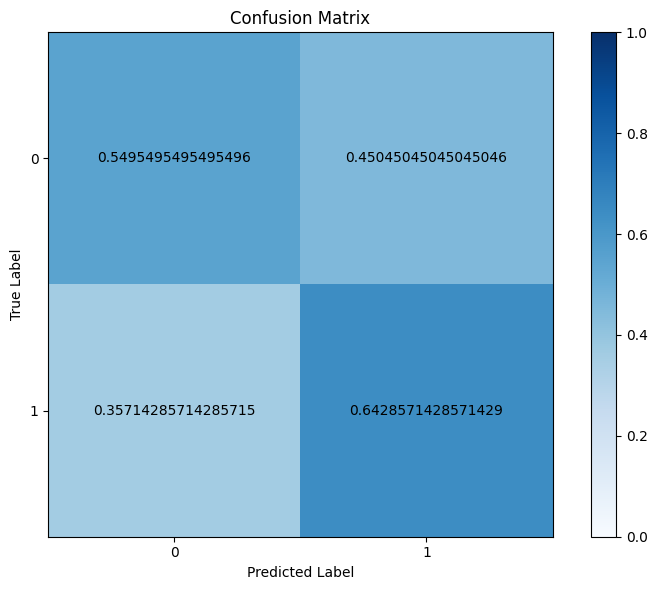

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 10


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2215, Adversarial loss: 0.7822, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.6033, Adversarial loss: 0.7623, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.5461, Adversarial loss: 0.7801, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.4972, Adversarial loss: 0.7679, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.4802, Adversarial loss: 0.7567, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.4858, Adversarial loss: 0.7502, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.4516, Adversarial loss: 0.7401, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.4485, Adversarial loss: 0.7396, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.4425, Adversarial loss: 0.7360, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_58 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5647 - loss: 0.7804 - val_accuracy: 0.4348 - val_loss: 0.8455
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.5650 - loss: 0.7484 - val_accuracy: 0.4855 - val_loss: 0.7763
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.6192 - loss: 0.6722 - val_accuracy: 0.5000 - val_loss: 0.7312
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.5973 - loss: 0.6525 - val_accuracy: 0.5435 - val_loss: 0.6941
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.6681 - loss: 0.6227 - val_accuracy: 0.6014 - val_loss: 0.6684
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6219 - val_accuracy: 0.6304 - val_loss: 0.6529
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6550 - loss: 0.6235 - val_accuracy: 0.6232 - val_loss: 0.6429
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6785 - loss: 0.5987 - val_accuracy: 0.63

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_59 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6032 - loss: 0.8443 - val_accuracy: 0.4493 - val_loss: 0.9685
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.6139 - loss: 0.7486 - val_accuracy: 0.4783 - val_loss: 0.8435
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.6426 - loss: 0.6813 - val_accuracy: 0.5362 - val_loss: 0.7662
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6274 - loss: 0.6683 - val_accuracy: 0.5797 - val_loss: 0.7167
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6550 - loss: 0.6293 - val_accuracy: 0.6014 - val_loss: 0.6856
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6515 - loss: 0.6364 - val_accuracy: 0.5797 - val_loss: 0.6706
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6364 - loss: 0.6283 - val_accuracy: 0.5725 - val_loss: 0.6620
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6650 - loss: 0.6119 - val_accuracy: 0.55

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_60 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 0.8498 - val_accuracy: 0.4058 - val_loss: 0.9905
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.6157 - loss: 0.7590 - val_accuracy: 0.4275 - val_loss: 0.8782
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6062 - loss: 0.7205 - val_accuracy: 0.4638 - val_loss: 0.7901
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6362 - loss: 0.6980 - val_accuracy: 0.5290 - val_loss: 0.7301
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6488 - loss: 0.6418 - val_accuracy: 0.5652 - val_loss: 0.6927
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6609 - loss: 0.6259 - val_accuracy: 0.5870 - val_loss: 0.6680
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6562 - loss: 0.6232 - val_accuracy: 0.5797 - val_loss: 0.6562
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.6514 - loss: 0.6201 - val_accuracy: 0.57

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_61 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4308 - loss: 1.1018 - val_accuracy: 0.5217 - val_loss: 0.8228
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.4531 - loss: 1.0036 - val_accuracy: 0.5290 - val_loss: 0.7754
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.5059 - loss: 0.8901 - val_accuracy: 0.5580 - val_loss: 0.7350
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5144 - loss: 0.8452 - val_accuracy: 0.5870 - val_loss: 0.7107
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.5302 - loss: 0.7652 - val_accuracy: 0.5870 - val_loss: 0.6902
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5743 - loss: 0.7164 - val_accuracy: 0.6087 - val_loss: 0.6701
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.5722 - loss: 0.7061 - val_accuracy: 0.6232 - val_loss: 0.6513
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.6007 - loss: 0.6800 - val_accuracy: 0.58

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_62 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4657 - loss: 0.9197 - val_accuracy: 0.6957 - val_loss: 0.5823
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.5257 - loss: 0.8119 - val_accuracy: 0.6667 - val_loss: 0.5983
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.5527 - loss: 0.7556 - val_accuracy: 0.6594 - val_loss: 0.6146
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.5939 - loss: 0.6999 - val_accuracy: 0.6449 - val_loss: 0.6325
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.5929 - loss: 0.6815 - val_accuracy: 0.6377 - val_loss: 0.6353
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.6281 - loss: 0.6595 - val_accuracy: 0.6304 - val_loss: 0.6359
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6252 - loss: 0.6623 - val_accuracy: 0.6304 - val_loss: 0.6391
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.6574 - loss: 0.6255 - val_accuracy: 0.61

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_63 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4703 - loss: 1.0332 - val_accuracy: 0.6232 - val_loss: 0.7262
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.5179 - loss: 0.8836 - val_accuracy: 0.5942 - val_loss: 0.7300
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5320 - loss: 0.8098 - val_accuracy: 0.6087 - val_loss: 0.7248
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.5806 - loss: 0.7571 - val_accuracy: 0.6014 - val_loss: 0.7143
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.5842 - loss: 0.7083 - val_accuracy: 0.5942 - val_loss: 0.6969
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6119 - loss: 0.6730 - val_accuracy: 0.6014 - val_loss: 0.6873
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6289 - loss: 0.6505 - val_accuracy: 0.5797 - val_loss: 0.6744
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6347 - loss: 0.6368 - val_accuracy: 0.58

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_64 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5728 - loss: 0.8127 - val_accuracy: 0.6812 - val_loss: 0.6453
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5914 - loss: 0.7389 - val_accuracy: 0.6667 - val_loss: 0.6688
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6302 - loss: 0.6852 - val_accuracy: 0.6522 - val_loss: 0.6733
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6318 - loss: 0.6549 - val_accuracy: 0.6232 - val_loss: 0.6781
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6551 - loss: 0.6231 - val_accuracy: 0.6377 - val_loss: 0.6767
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6548 - loss: 0.6280 - val_accuracy: 0.6377 - val_loss: 0.6677
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6947 - loss: 0.6018 - val_accuracy: 0.6522 - val_loss: 0.6642
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6741 - loss: 0.5938 - val_accuracy: 0.65

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_65 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5226 - loss: 0.7894 - val_accuracy: 0.3478 - val_loss: 0.8581
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.5633 - loss: 0.7097 - val_accuracy: 0.3986 - val_loss: 0.7866
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6775 - val_accuracy: 0.4565 - val_loss: 0.7323
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6211 - loss: 0.6479 - val_accuracy: 0.5072 - val_loss: 0.6938
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6491 - loss: 0.6216 - val_accuracy: 0.5652 - val_loss: 0.6706
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6572 - loss: 0.6152 - val_accuracy: 0.5797 - val_loss: 0.6560
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6687 - loss: 0.6043 - val_accuracy: 0.6014 - val_loss: 0.6534
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6594 - loss: 0.6003 - val_accuracy: 0.6304

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_66 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4465 - loss: 1.2588 - val_accuracy: 0.6667 - val_loss: 0.6714
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4589 - loss: 1.0995 - val_accuracy: 0.6667 - val_loss: 0.6642
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4996 - loss: 0.9787 - val_accuracy: 0.6377 - val_loss: 0.6509
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5008 - loss: 0.9039 - val_accuracy: 0.6449 - val_loss: 0.6493
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.5381 - loss: 0.8294 - val_accuracy: 0.6232 - val_loss: 0.6419
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5533 - loss: 0.7866 - val_accuracy: 0.6377 - val_loss: 0.6306
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5535 - loss: 0.7483 - val_accuracy: 0.6522 - val_loss: 0.6256
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5843 - loss: 0.7116 - val_accuracy: 0.6667

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_67 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3927 - loss: 1.9054 - val_accuracy: 0.3913 - val_loss: 1.7122
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.3980 - loss: 1.6519 - val_accuracy: 0.3768 - val_loss: 1.4117
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4058 - loss: 1.4217 - val_accuracy: 0.3986 - val_loss: 1.1642
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4084 - loss: 1.1839 - val_accuracy: 0.4130 - val_loss: 0.9885
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4307 - loss: 1.0383 - val_accuracy: 0.4203 - val_loss: 0.8749
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.4693 - loss: 0.8956 - val_accuracy: 0.4420 - val_loss: 0.7984
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5043 - loss: 0.8036 - val_accuracy: 0.4855 - val_loss: 0.7489
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.5361 - loss: 0.7405 - val_accuracy: 0.50

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_68 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4934 - loss: 1.1216 - val_accuracy: 0.5217 - val_loss: 0.8399
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.5147 - loss: 1.0343 - val_accuracy: 0.5870 - val_loss: 0.7646
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5189 - loss: 0.9460 - val_accuracy: 0.6232 - val_loss: 0.7186
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5490 - loss: 0.8759 - val_accuracy: 0.6087 - val_loss: 0.6962
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5599 - loss: 0.8294 - val_accuracy: 0.6159 - val_loss: 0.6868
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5609 - loss: 0.7613 - val_accuracy: 0.6232 - val_loss: 0.6803
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5874 - loss: 0.7110 - val_accuracy: 0.6087 - val_loss: 0.6603
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6254 - loss: 0.6702 - val_accuracy: 0.62

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_69 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3858 - loss: 1.2088 - val_accuracy: 0.3261 - val_loss: 1.0758
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.4491 - loss: 0.9634 - val_accuracy: 0.3986 - val_loss: 0.8545
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4956 - loss: 0.8139 - val_accuracy: 0.5145 - val_loss: 0.7339
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5570 - loss: 0.7239 - val_accuracy: 0.5870 - val_loss: 0.6648
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6045 - loss: 0.6622 - val_accuracy: 0.6377 - val_loss: 0.6420
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6302 - loss: 0.6334 - val_accuracy: 0.6522 - val_loss: 0.6301
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6755 - loss: 0.6031 - val_accuracy: 0.6739 - val_loss: 0.6187
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6864 - loss: 0.6026 - val_accuracy: 0.65

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_70 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4905 - loss: 1.2822 - val_accuracy: 0.7391 - val_loss: 0.5596
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4807 - loss: 1.0744 - val_accuracy: 0.6884 - val_loss: 0.6026
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5017 - loss: 0.8936 - val_accuracy: 0.6377 - val_loss: 0.6458
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5122 - loss: 0.7907 - val_accuracy: 0.6304 - val_loss: 0.6699
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5497 - loss: 0.7228 - val_accuracy: 0.6159 - val_loss: 0.6815
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5857 - loss: 0.6787 - val_accuracy: 0.6014 - val_loss: 0.6882
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6229 - loss: 0.6549 - val_accuracy: 0.6232 - val_loss: 0.6879
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.6422 - loss: 0.6321 - val_accuracy: 0.61

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_71 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5633 - loss: 0.9853 - val_accuracy: 0.3768 - val_loss: 1.3618
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6055 - loss: 0.8710 - val_accuracy: 0.4348 - val_loss: 1.1317
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6265 - loss: 0.7565 - val_accuracy: 0.5000 - val_loss: 0.9719
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.6726 - val_accuracy: 0.5435 - val_loss: 0.8778
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6698 - loss: 0.6494 - val_accuracy: 0.5652 - val_loss: 0.8111
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.6840 - loss: 0.6144 - val_accuracy: 0.5797 - val_loss: 0.7749
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6951 - loss: 0.5977 - val_accuracy: 0.5725 - val_loss: 0.7440
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.7118 - loss: 0.5725 - val_accuracy: 0.5797

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_72 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6373 - loss: 0.7672 - val_accuracy: 0.5217 - val_loss: 0.8597
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6530 - loss: 0.7098 - val_accuracy: 0.5580 - val_loss: 0.8204
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.6786 - loss: 0.6603 - val_accuracy: 0.5725 - val_loss: 0.7924
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6927 - loss: 0.6073 - val_accuracy: 0.5870 - val_loss: 0.7771
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.7068 - loss: 0.5860 - val_accuracy: 0.5870 - val_loss: 0.7499
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.7337 - loss: 0.5419 - val_accuracy: 0.6014 - val_loss: 0.7403
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.7310 - loss: 0.5512 - val_accuracy: 0.6014 - val_loss: 0.7341
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.7256 - loss: 0.5464 - val_accuracy: 0.6014

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_73 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 0.6983 - val_accuracy: 0.3986 - val_loss: 1.1582
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7086 - loss: 0.6178 - val_accuracy: 0.4855 - val_loss: 1.0094
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.7341 - loss: 0.5509 - val_accuracy: 0.5217 - val_loss: 0.9013
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7470 - loss: 0.5263 - val_accuracy: 0.5725 - val_loss: 0.8366
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.7711 - loss: 0.4861 - val_accuracy: 0.6159 - val_loss: 0.7927
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7810 - loss: 0.4585 - val_accuracy: 0.6232 - val_loss: 0.7601
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.8015 - loss: 0.4318 - val_accuracy: 0.6232 - val_loss: 0.7495
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.8020 - loss: 0.4396 - val_accuracy: 0.6304

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_74 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3998 - loss: 1.1831 - val_accuracy: 0.6159 - val_loss: 0.6573
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.4725 - loss: 0.9158 - val_accuracy: 0.5217 - val_loss: 0.7039
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.5728 - loss: 0.7298 - val_accuracy: 0.5217 - val_loss: 0.7309
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6594 - loss: 0.6194 - val_accuracy: 0.5362 - val_loss: 0.7396
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7020 - loss: 0.5570 - val_accuracy: 0.5870 - val_loss: 0.7409
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7561 - loss: 0.4885 - val_accuracy: 0.6232 - val_loss: 0.7311
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7839 - loss: 0.4643 - val_accuracy: 0.6522 - val_loss: 0.7309
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.8210 - loss: 0.4223 - val_accuracy: 0.66

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_75 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5396 - loss: 1.1027 - val_accuracy: 0.2029 - val_loss: 1.7294
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.5915 - loss: 0.7983 - val_accuracy: 0.3406 - val_loss: 1.2266
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6736 - loss: 0.6193 - val_accuracy: 0.4348 - val_loss: 0.9915
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7159 - loss: 0.5513 - val_accuracy: 0.5145 - val_loss: 0.9038
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.7618 - loss: 0.4868 - val_accuracy: 0.5362 - val_loss: 0.8547
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7825 - loss: 0.4471 - val_accuracy: 0.5652 - val_loss: 0.8461
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.8180 - loss: 0.4116 - val_accuracy: 0.5652 - val_loss: 0.8344
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.8264 - loss: 0.3997 - val_accuracy: 0.58

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_76 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 1.1033 - val_accuracy: 0.3841 - val_loss: 1.2340
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5516 - loss: 0.8455 - val_accuracy: 0.3551 - val_loss: 1.0771
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6131 - loss: 0.6956 - val_accuracy: 0.4203 - val_loss: 0.9443
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7144 - loss: 0.5505 - val_accuracy: 0.5072 - val_loss: 0.8587
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7915 - loss: 0.4661 - val_accuracy: 0.5507 - val_loss: 0.8237
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8328 - loss: 0.4111 - val_accuracy: 0.5652 - val_loss: 0.8029
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.8550 - loss: 0.3771 - val_accuracy: 0.5942 - val_loss: 0.8101
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8552 - loss: 0.3665 - val_accuracy: 0.6159

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_77 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6959 - loss: 0.5920 - val_accuracy: 0.5507 - val_loss: 0.7868
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7461 - loss: 0.5203 - val_accuracy: 0.5652 - val_loss: 0.8180
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.7786 - loss: 0.4639 - val_accuracy: 0.5580 - val_loss: 0.8481
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.8204 - loss: 0.4095 - val_accuracy: 0.5725 - val_loss: 0.8597
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.8371 - loss: 0.3935 - val_accuracy: 0.5870 - val_loss: 0.8794
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.8581 - loss: 0.3601 - val_accuracy: 0.5870 - val_loss: 0.9054
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.8721 - loss: 0.3336 - val_accuracy: 0.5942 - val_loss: 0.9334
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8632 - loss: 0.3265 - val_accuracy: 0.58

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_78 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3479 - loss: 1.6520 - val_accuracy: 0.4130 - val_loss: 1.0311
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.4019 - loss: 1.3006 - val_accuracy: 0.3551 - val_loss: 1.0456
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.4629 - loss: 1.0798 - val_accuracy: 0.3768 - val_loss: 1.0185
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.5314 - loss: 0.9159 - val_accuracy: 0.3768 - val_loss: 0.9485
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.5833 - loss: 0.7787 - val_accuracy: 0.4275 - val_loss: 0.8875
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6514 - loss: 0.6618 - val_accuracy: 0.4348 - val_loss: 0.8380
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6896 - loss: 0.5702 - val_accuracy: 0.4710 - val_loss: 0.7954
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7525 - loss: 0.4959 - val_accuracy: 0.49

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_79 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4978 - loss: 1.6388 - val_accuracy: 0.8768 - val_loss: 0.3724
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.5119 - loss: 1.1791 - val_accuracy: 0.8261 - val_loss: 0.4055
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5831 - loss: 0.8148 - val_accuracy: 0.8043 - val_loss: 0.4824
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6783 - loss: 0.6176 - val_accuracy: 0.6957 - val_loss: 0.5646
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.7438 - loss: 0.5283 - val_accuracy: 0.6304 - val_loss: 0.6178
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7483 - loss: 0.5030 - val_accuracy: 0.6087 - val_loss: 0.6584
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8048 - loss: 0.4528 - val_accuracy: 0.6159 - val_loss: 0.6778
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.8239 - loss: 0.4204 - val_accuracy: 0.6232

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_80 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4176 - loss: 1.2507 - val_accuracy: 0.5362 - val_loss: 0.7136
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.5141 - loss: 0.8996 - val_accuracy: 0.4130 - val_loss: 0.8524
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5658 - loss: 0.7172 - val_accuracy: 0.3768 - val_loss: 0.9454
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6393 - loss: 0.6470 - val_accuracy: 0.3551 - val_loss: 1.0008
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7271 - loss: 0.5322 - val_accuracy: 0.3913 - val_loss: 1.0200
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7505 - loss: 0.5037 - val_accuracy: 0.4130 - val_loss: 1.0228
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7906 - loss: 0.4567 - val_accuracy: 0.4420 - val_loss: 1.0307
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.8008 - loss: 0.4242 - val_accuracy: 0.4855

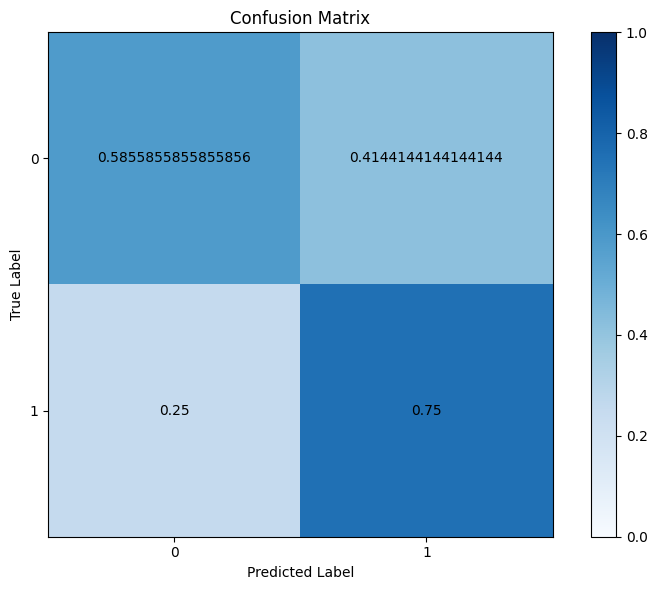

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 100


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2130, Adversarial loss: 0.8025, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.6141, Adversarial loss: 0.8087, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.5661, Adversarial loss: 0.8109, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.5250, Adversarial loss: 0.8069, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.5008, Adversarial loss: 0.8009, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.4960, Adversarial loss: 0.8088, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.4630, Adversarial loss: 0.8069, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.4553, Adversarial loss: 0.8072, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.4456, Adversarial loss: 0.8074, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_87 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4907 - loss: 1.0774 - val_accuracy: 0.5942 - val_loss: 0.6649
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.5848 - loss: 0.8185 - val_accuracy: 0.6159 - val_loss: 0.6724
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6202 - loss: 0.7191 - val_accuracy: 0.6304 - val_loss: 0.6336
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6264 - loss: 0.6997 - val_accuracy: 0.6377 - val_loss: 0.6082
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6430 - loss: 0.6525 - val_accuracy: 0.6812 - val_loss: 0.5876
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6698 - loss: 0.6225 - val_accuracy: 0.6522 - val_loss: 0.6064
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6827 - loss: 0.6180 - val_accuracy: 0.6522 - val_loss: 0.6078
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6760 - loss: 0.6059 - val_accuracy: 0.6594

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_88 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6117 - loss: 0.8119 - val_accuracy: 0.6667 - val_loss: 0.6985
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.6408 - loss: 0.6940 - val_accuracy: 0.6812 - val_loss: 0.6524
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6619 - loss: 0.6615 - val_accuracy: 0.7246 - val_loss: 0.5921
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.6530 - loss: 0.6256 - val_accuracy: 0.7029 - val_loss: 0.5926
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6669 - loss: 0.6255 - val_accuracy: 0.7174 - val_loss: 0.5781
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6776 - loss: 0.6136 - val_accuracy: 0.7536 - val_loss: 0.5631
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.6701 - loss: 0.6004 - val_accuracy: 0.7319 - val_loss: 0.5645
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.5973 - val_accuracy: 0.7319

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_89 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 1.2345 - val_accuracy: 0.5652 - val_loss: 0.7210
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.5979 - loss: 0.8012 - val_accuracy: 0.5870 - val_loss: 0.6644
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.6168 - loss: 0.7347 - val_accuracy: 0.6014 - val_loss: 0.6625
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6159 - loss: 0.7323 - val_accuracy: 0.6304 - val_loss: 0.6402
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6393 - loss: 0.6851 - val_accuracy: 0.6594 - val_loss: 0.6067
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6594 - loss: 0.6449 - val_accuracy: 0.6739 - val_loss: 0.5970
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6723 - loss: 0.6313 - val_accuracy: 0.6594 - val_loss: 0.6117
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6761 - loss: 0.6177 - val_accuracy: 0.68

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_90 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5876 - loss: 0.8770 - val_accuracy: 0.7101 - val_loss: 0.5862
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6351 - loss: 0.7067 - val_accuracy: 0.7029 - val_loss: 0.5588
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6433 - loss: 0.6788 - val_accuracy: 0.7029 - val_loss: 0.5624
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6648 - loss: 0.6473 - val_accuracy: 0.6667 - val_loss: 0.5931
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6553 - loss: 0.6514 - val_accuracy: 0.6739 - val_loss: 0.5757
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6721 - loss: 0.6184 - val_accuracy: 0.6812 - val_loss: 0.5696
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6914 - loss: 0.6186 - val_accuracy: 0.6667 - val_loss: 0.5757
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.6770 - loss: 0.5993 - val_accuracy: 0.6739

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_91 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4826 - loss: 1.1743 - val_accuracy: 0.6087 - val_loss: 0.6570
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.5982 - loss: 0.7580 - val_accuracy: 0.6014 - val_loss: 0.6675
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 0.7249 - val_accuracy: 0.6522 - val_loss: 0.6572
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6417 - loss: 0.6704 - val_accuracy: 0.6594 - val_loss: 0.6340
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6410 - loss: 0.6654 - val_accuracy: 0.6449 - val_loss: 0.6257
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.6646 - loss: 0.6313 - val_accuracy: 0.6739 - val_loss: 0.5990
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6588 - loss: 0.6252 - val_accuracy: 0.6739 - val_loss: 0.5966
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6932 - loss: 0.5861 - val_accuracy: 0.6739

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_92 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 0.8418 - val_accuracy: 0.5797 - val_loss: 0.6984
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6302 - loss: 0.6506 - val_accuracy: 0.6667 - val_loss: 0.6346
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6840 - loss: 0.6209 - val_accuracy: 0.6522 - val_loss: 0.6294
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6746 - loss: 0.6029 - val_accuracy: 0.6594 - val_loss: 0.6166
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6932 - loss: 0.5848 - val_accuracy: 0.6739 - val_loss: 0.6132
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.7081 - loss: 0.5816 - val_accuracy: 0.6594 - val_loss: 0.6210
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7004 - loss: 0.5769 - val_accuracy: 0.6957 - val_loss: 0.6059
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6972 - loss: 0.5838 - val_accuracy: 0.69

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_93 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 0.9232 - val_accuracy: 0.6087 - val_loss: 0.7139
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.5912 - loss: 0.7742 - val_accuracy: 0.6232 - val_loss: 0.6682
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.6283 - loss: 0.7164 - val_accuracy: 0.6087 - val_loss: 0.6694
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.6360 - loss: 0.6826 - val_accuracy: 0.6304 - val_loss: 0.6475
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6608 - loss: 0.6558 - val_accuracy: 0.6232 - val_loss: 0.6466
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.6720 - loss: 0.6372 - val_accuracy: 0.6449 - val_loss: 0.6115
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6824 - loss: 0.6204 - val_accuracy: 0.6739 - val_loss: 0.6042
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6806 - loss: 0.6184 - val_accuracy: 0.64

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_94 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5875 - loss: 0.8546 - val_accuracy: 0.6449 - val_loss: 0.6725
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.6240 - loss: 0.6975 - val_accuracy: 0.6377 - val_loss: 0.6595
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6701 - loss: 0.6497 - val_accuracy: 0.6594 - val_loss: 0.6216
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6704 - loss: 0.6235 - val_accuracy: 0.6812 - val_loss: 0.6133
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6767 - loss: 0.6123 - val_accuracy: 0.6667 - val_loss: 0.6227
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6783 - loss: 0.6077 - val_accuracy: 0.6884 - val_loss: 0.6138
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6931 - loss: 0.5934 - val_accuracy: 0.6884 - val_loss: 0.6002
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6964 - loss: 0.5929 - val_accuracy: 0.68

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_95 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5707 - loss: 0.8102 - val_accuracy: 0.6739 - val_loss: 0.5847
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6366 - loss: 0.6947 - val_accuracy: 0.6884 - val_loss: 0.5809
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6621 - loss: 0.6627 - val_accuracy: 0.6812 - val_loss: 0.6139
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6888 - loss: 0.6175 - val_accuracy: 0.6739 - val_loss: 0.6218
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.6853 - loss: 0.6109 - val_accuracy: 0.6739 - val_loss: 0.6199
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.6799 - loss: 0.6104 - val_accuracy: 0.6594 - val_loss: 0.6327
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6948 - loss: 0.5922 - val_accuracy: 0.6377 - val_loss: 0.6360
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6809 - loss: 0.6050 - val_accuracy: 0.65

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_96 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6009 - loss: 0.7931 - val_accuracy: 0.6522 - val_loss: 0.6519
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.6659 - loss: 0.6944 - val_accuracy: 0.6884 - val_loss: 0.6283
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.6815 - loss: 0.6562 - val_accuracy: 0.7029 - val_loss: 0.6229
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6879 - loss: 0.6240 - val_accuracy: 0.6957 - val_loss: 0.6217
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6929 - loss: 0.6172 - val_accuracy: 0.6884 - val_loss: 0.6136
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6821 - loss: 0.6107 - val_accuracy: 0.7101 - val_loss: 0.5964
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6924 - loss: 0.6008 - val_accuracy: 0.6957 - val_loss: 0.6005
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7007 - loss: 0.5853 - val_accuracy: 0.70

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_97 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.9928 - val_accuracy: 0.6522 - val_loss: 0.6537
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6207 - loss: 0.7556 - val_accuracy: 0.6667 - val_loss: 0.6494
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6626 - loss: 0.6480 - val_accuracy: 0.6667 - val_loss: 0.6408
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6781 - loss: 0.6290 - val_accuracy: 0.6812 - val_loss: 0.6466
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.6674 - loss: 0.6259 - val_accuracy: 0.6957 - val_loss: 0.6316
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.7099 - loss: 0.5971 - val_accuracy: 0.6884 - val_loss: 0.6259
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6928 - loss: 0.5944 - val_accuracy: 0.6884 - val_loss: 0.6277
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.7047 - loss: 0.5836 - val_accuracy: 0.69

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_98 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6359 - loss: 0.8560 - val_accuracy: 0.6739 - val_loss: 0.6492
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.6928 - loss: 0.6748 - val_accuracy: 0.6594 - val_loss: 0.6003
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6817 - loss: 0.6148 - val_accuracy: 0.6522 - val_loss: 0.5915
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6892 - loss: 0.5953 - val_accuracy: 0.6957 - val_loss: 0.5635
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7037 - loss: 0.5895 - val_accuracy: 0.6812 - val_loss: 0.5807
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7030 - loss: 0.5898 - val_accuracy: 0.7029 - val_loss: 0.5687
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7098 - loss: 0.5754 - val_accuracy: 0.6884 - val_loss: 0.5724
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7067 - loss: 0.5835 - val_accuracy: 0.68

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_99 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5422 - loss: 0.9457 - val_accuracy: 0.6739 - val_loss: 0.5560
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6078 - loss: 0.7633 - val_accuracy: 0.6884 - val_loss: 0.5916
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6335 - loss: 0.7356 - val_accuracy: 0.7029 - val_loss: 0.5903
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6787 - loss: 0.6571 - val_accuracy: 0.6957 - val_loss: 0.5824
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6905 - loss: 0.6244 - val_accuracy: 0.6812 - val_loss: 0.5971
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6838 - loss: 0.6285 - val_accuracy: 0.6667 - val_loss: 0.5961
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6755 - loss: 0.6309 - val_accuracy: 0.6884 - val_loss: 0.5895
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6789 - loss: 0.6260 - val_accuracy: 0.6812

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_100 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5184 - loss: 1.0006 - val_accuracy: 0.7101 - val_loss: 0.5268
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6010 - loss: 0.7888 - val_accuracy: 0.6957 - val_loss: 0.5696
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6632 - loss: 0.6872 - val_accuracy: 0.6884 - val_loss: 0.5987
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6531 - loss: 0.6703 - val_accuracy: 0.7029 - val_loss: 0.5951
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.6730 - loss: 0.6460 - val_accuracy: 0.7029 - val_loss: 0.6106
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6816 - loss: 0.6172 - val_accuracy: 0.6884 - val_loss: 0.6174
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.7051 - loss: 0.5974 - val_accuracy: 0.7101 - val_loss: 0.6064
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.7126 - loss: 0.5779 - val_accuracy: 0.7

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_101 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5529 - loss: 1.0006 - val_accuracy: 0.6522 - val_loss: 0.6258
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.6776 - loss: 0.7056 - val_accuracy: 0.6522 - val_loss: 0.6045
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6983 - loss: 0.6551 - val_accuracy: 0.6377 - val_loss: 0.6040
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6774 - loss: 0.6409 - val_accuracy: 0.6594 - val_loss: 0.5937
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6959 - loss: 0.6331 - val_accuracy: 0.6812 - val_loss: 0.5824
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6873 - loss: 0.6019 - val_accuracy: 0.6812 - val_loss: 0.5859
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.7070 - loss: 0.5882 - val_accuracy: 0.6957 - val_loss: 0.5795
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6920 - loss: 0.5936 - val_accuracy: 0.68

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_102 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5309 - loss: 1.0217 - val_accuracy: 0.6449 - val_loss: 0.7106
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.6378 - loss: 0.7551 - val_accuracy: 0.6522 - val_loss: 0.7079
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6533 - loss: 0.6777 - val_accuracy: 0.6232 - val_loss: 0.6879
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6962 - loss: 0.6219 - val_accuracy: 0.6304 - val_loss: 0.6589
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6878 - loss: 0.6342 - val_accuracy: 0.6377 - val_loss: 0.6703
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6907 - loss: 0.6093 - val_accuracy: 0.6522 - val_loss: 0.6496
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.7017 - loss: 0.5937 - val_accuracy: 0.6594 - val_loss: 0.6382
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6928 - loss: 0.5816 - val_accuracy: 0.65

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_103 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.8901 - val_accuracy: 0.6812 - val_loss: 0.6615
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6546 - loss: 0.6896 - val_accuracy: 0.7174 - val_loss: 0.6364
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6438 - loss: 0.6812 - val_accuracy: 0.7029 - val_loss: 0.6496
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.6826 - loss: 0.6399 - val_accuracy: 0.7101 - val_loss: 0.6244
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6905 - loss: 0.6238 - val_accuracy: 0.7319 - val_loss: 0.6195
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6857 - loss: 0.6089 - val_accuracy: 0.7391 - val_loss: 0.6172
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6926 - loss: 0.6041 - val_accuracy: 0.7319 - val_loss: 0.6207
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7022 - loss: 0.5755 - val_accuracy: 0.73

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_104 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5143 - loss: 0.9737 - val_accuracy: 0.6812 - val_loss: 0.6474
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6070 - loss: 0.7525 - val_accuracy: 0.6667 - val_loss: 0.6547
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6626 - loss: 0.6743 - val_accuracy: 0.6957 - val_loss: 0.6155
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6714 - loss: 0.6376 - val_accuracy: 0.6812 - val_loss: 0.6239
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6814 - loss: 0.6133 - val_accuracy: 0.7029 - val_loss: 0.6095
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6860 - loss: 0.6196 - val_accuracy: 0.6957 - val_loss: 0.6108
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6929 - loss: 0.6055 - val_accuracy: 0.6884 - val_loss: 0.6038
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7008 - loss: 0.5975 - val_accuracy: 0.69

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_105 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5746 - loss: 0.9177 - val_accuracy: 0.6957 - val_loss: 0.6155
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.6385 - loss: 0.7269 - val_accuracy: 0.7029 - val_loss: 0.6011
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.6475 - loss: 0.6958 - val_accuracy: 0.7174 - val_loss: 0.5825
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6713 - loss: 0.6408 - val_accuracy: 0.6957 - val_loss: 0.6089
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6873 - loss: 0.6274 - val_accuracy: 0.7174 - val_loss: 0.5993
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6903 - loss: 0.6225 - val_accuracy: 0.7029 - val_loss: 0.6189
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6843 - loss: 0.6198 - val_accuracy: 0.7246 - val_loss: 0.5972
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6864 - loss: 0.6060 - val_accuracy: 0.72

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_106 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4600 - loss: 1.1096 - val_accuracy: 0.5942 - val_loss: 0.6739
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6238 - loss: 0.7235 - val_accuracy: 0.6522 - val_loss: 0.6202
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6354 - loss: 0.6838 - val_accuracy: 0.6304 - val_loss: 0.6219
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6669 - loss: 0.6393 - val_accuracy: 0.6377 - val_loss: 0.6146
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6357 - loss: 0.6445 - val_accuracy: 0.6232 - val_loss: 0.6134
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.6589 - loss: 0.6251 - val_accuracy: 0.5942 - val_loss: 0.6308
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6663 - loss: 0.6114 - val_accuracy: 0.6087 - val_loss: 0.6218
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6680 - loss: 0.6157 - val_accuracy: 0.61

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_107 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5487 - loss: 0.9300 - val_accuracy: 0.6304 - val_loss: 0.6531
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6248 - loss: 0.7574 - val_accuracy: 0.6522 - val_loss: 0.6278
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.6623 - loss: 0.7092 - val_accuracy: 0.6522 - val_loss: 0.6172
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6717 - loss: 0.6792 - val_accuracy: 0.6594 - val_loss: 0.6099
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6774 - loss: 0.6292 - val_accuracy: 0.6594 - val_loss: 0.6262
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.6753 - loss: 0.6146 - val_accuracy: 0.6957 - val_loss: 0.6099
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6873 - loss: 0.6092 - val_accuracy: 0.7101 - val_loss: 0.5997
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.6807 - loss: 0.6047 - val_accuracy: 0.70

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_108 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4987 - loss: 1.0263 - val_accuracy: 0.6667 - val_loss: 0.6685
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.6419 - loss: 0.6991 - val_accuracy: 0.6812 - val_loss: 0.6537
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6751 - loss: 0.6403 - val_accuracy: 0.6812 - val_loss: 0.6386
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6506 - loss: 0.6446 - val_accuracy: 0.6522 - val_loss: 0.6490
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6975 - loss: 0.5991 - val_accuracy: 0.6594 - val_loss: 0.6467
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6946 - loss: 0.6165 - val_accuracy: 0.6594 - val_loss: 0.6350
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.7033 - loss: 0.5880 - val_accuracy: 0.6667 - val_loss: 0.6350
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6981 - loss: 0.5833 - val_accuracy: 0.65

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_109 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.3451 - val_accuracy: 0.6014 - val_loss: 0.7908
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.7858 - val_accuracy: 0.6014 - val_loss: 0.7725
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6580 - loss: 0.7176 - val_accuracy: 0.6014 - val_loss: 0.7436
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6631 - loss: 0.6852 - val_accuracy: 0.6087 - val_loss: 0.7345
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6607 - loss: 0.6560 - val_accuracy: 0.6159 - val_loss: 0.7137
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.6721 - loss: 0.6573 - val_accuracy: 0.6232 - val_loss: 0.6946
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6919 - loss: 0.6166 - val_accuracy: 0.6377 - val_loss: 0.6916
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6776 - loss: 0.6101 - val_accuracy: 0.6232

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_110 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5281 - loss: 0.9584 - val_accuracy: 0.6812 - val_loss: 0.5898
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.6502 - loss: 0.6814 - val_accuracy: 0.6594 - val_loss: 0.6284
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.6630 - loss: 0.6653 - val_accuracy: 0.6522 - val_loss: 0.6359
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.6842 - loss: 0.6122 - val_accuracy: 0.6449 - val_loss: 0.6342
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6913 - loss: 0.6090 - val_accuracy: 0.6594 - val_loss: 0.6183
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6777 - loss: 0.6104 - val_accuracy: 0.6739 - val_loss: 0.6125
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6857 - loss: 0.6005 - val_accuracy: 0.6957 - val_loss: 0.6011
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6849 - loss: 0.5956 - val_accuracy: 0.68

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_111 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 1.0628 - val_accuracy: 0.5797 - val_loss: 0.7776
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6575 - loss: 0.6942 - val_accuracy: 0.6304 - val_loss: 0.6883
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6593 - loss: 0.6721 - val_accuracy: 0.6377 - val_loss: 0.6714
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6983 - loss: 0.6092 - val_accuracy: 0.6522 - val_loss: 0.6455
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6912 - loss: 0.6063 - val_accuracy: 0.6449 - val_loss: 0.6395
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6805 - loss: 0.5880 - val_accuracy: 0.6449 - val_loss: 0.6456
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.7245 - loss: 0.5761 - val_accuracy: 0.6522 - val_loss: 0.6322
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7135 - loss: 0.5739 - val_accuracy: 0.6667

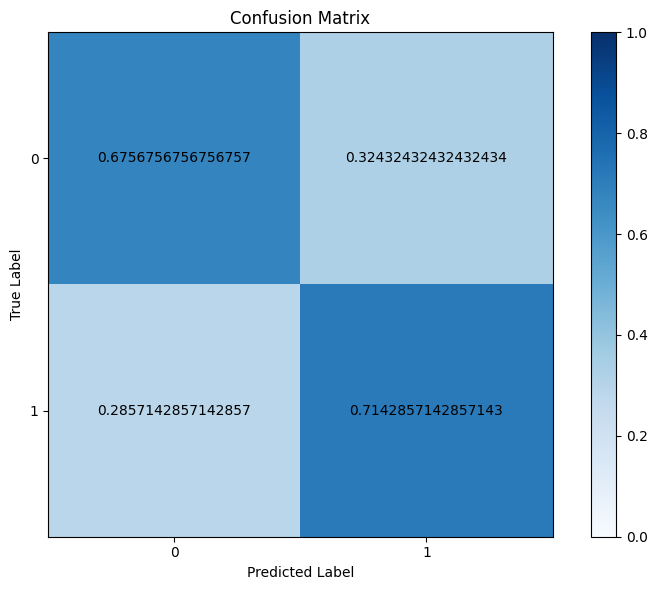

In [3]:
seed = 42
latent_space_dim = [5, 10, 100]

for dim in latent_space_dim:

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(latent_space_dim), 2, 2))

    output_dir=f"../results/ls_dimension_study/dim{dim}"
    os.makedirs(output_dir, exist_ok=True)
    
    config_ae = {
                'batch_size': 30,
                'epochs': 15,
                'learning_rate': 0.001,
                'seed': seed,
                'latent_dim': dim,
                'GaussianNoise_std': 0.003,
                'lambda_recon': 5,
                'lambda_adv': 1,
            }

    config_cellfate = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': seed,
        'latent_dim': dim,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }

    config_clf = {
        'batch_size': 30,
        'epochs': 50,
        'learning_rate': 0.001,
        'seed': seed,
        'latent_dim': dim,
    }

    results_autoencoder = train_autoencoder(config_ae, x_train)
    encoder = results_autoencoder['encoder']
    decoder = results_autoencoder['decoder']
    discriminator = results_autoencoder['discriminator']

    # IMAGES: Train AIcellfate with smaller dataset

    results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
    encoder = results_cellfate['encoder']
    decoder = results_cellfate['decoder']
    discriminator = results_cellfate['discriminator']

    save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)

    evaluator = Evaluation(output_dir)

    # Evaluate the model (and saving everything)
    z_imgs = encoder.predict(x_train)
    recon_imgs = decoder.predict(z_imgs)
    evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
    evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
    cov_matrix = cov_loss_terms(z_imgs)[0]
    evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

    tf.keras.utils.set_random_seed(config_clf['seed'])

    classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

    x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
    history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

    y_pred = classifier.predict(x_test_)
    y_pred_classes = np.argmax(y_pred, axis=1)
    num_classes = len(np.unique(y_test_))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    confusion_matrices_cellfate[latent_space_dim.index(dim)] = conf_matrix_normalized

    # Save confusion matrix
    plot_confusion_matrix(y_test_, y_pred, num_classes)
    np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

    

### TODO: show feature correlation with classification 

In [22]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 10,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim10/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim10/decoder.weights.h5")


In [23]:
latent_space = encoder.predict(x_train)
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:] 

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


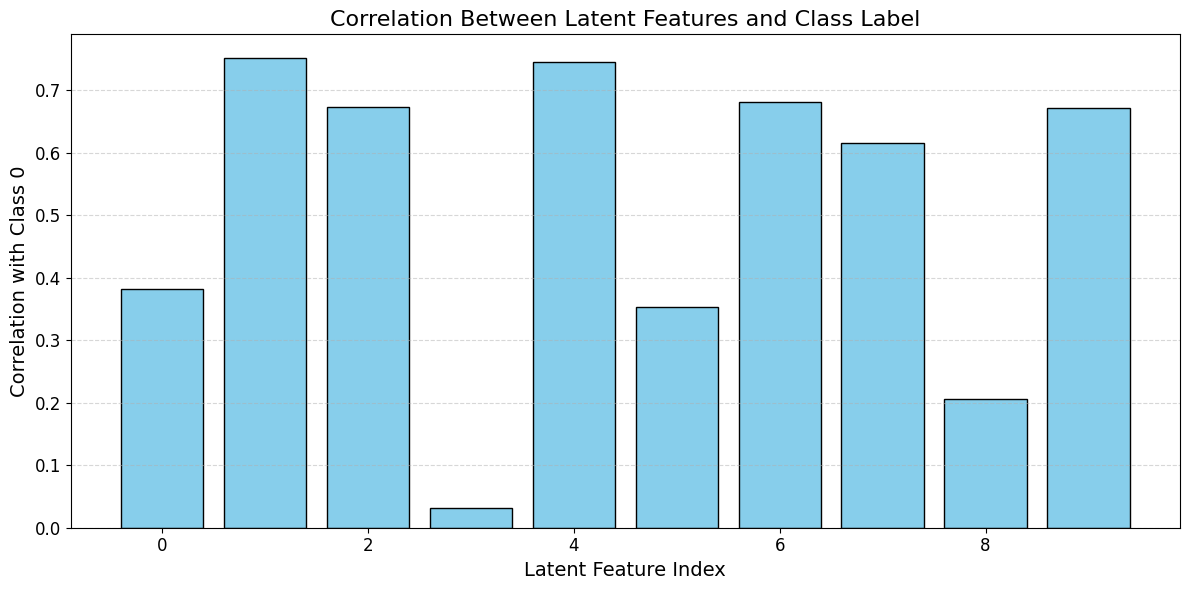

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: Feature indices (0 to 99)
feature_indices = np.arange(len(cor_vals))

plt.figure(figsize=(12, 6))
bars = plt.bar(feature_indices, abs(cor_vals), color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Latent Feature Index", fontsize=14)
plt.ylabel("Correlation with Class 0", fontsize=14)
plt.title("Correlation Between Latent Features and Class Label", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optionally highlight strongest features (e.g., top 5 absolute correlations)
# top_features = np.argsort(np.abs(cor_vals))[-5:]
# for i in top_features:
#     bars[i].set_color('orange')

# Optional: Save plot
# plt.savefig("latent_feature_correlations.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


### Conclusion: it's harder to disentangle...

(10, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(10, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(10, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(10, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(10, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


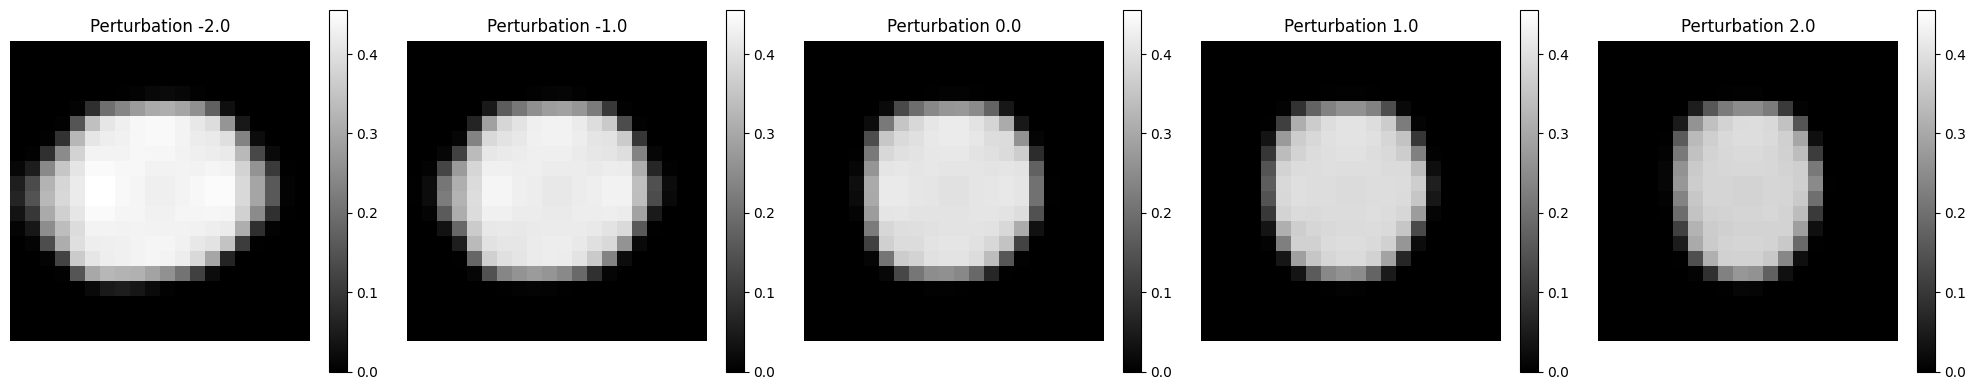

In [28]:
# Load the models after all the training and check the perturbations
baseline_latent_vector = np.zeros((latent_space.shape[1], latent_space.shape[1]), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 4

# Perturbation range
perturbations = np.linspace(-2, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
